20200120

5章　誤差逆伝搬法

重みのパラメータの勾配＝損失関数の勾配は、数値微分で求めた  
シンプルだが、計算に時間がかかる。  

↓

誤差逆伝搬法

[[DeepLearning] 計算グラフについて理解する - Qiita](https://qiita.com/edo_m18/items/7c95593ed5844b5a0c3b)

# 計算グラフ

微分という計算をグラフ化することでとても簡単に行える

<img src="./fig/https___qiita-image-store.s3.amazonaws.com_0_5616_a9356ddc-be79-4d82-5bed-379dd912fc6c.png">

計算グラフの使い方
1. 計算グラフを構築
2. 計算グラフ上で計算を左から右へ進める

計算を左から右へ進める ＝　順伝播  
計算を右から左へ進める ＝　逆伝播  

局所的な計算ですむ

<img src="./fig/https___qiita-image-store.s3.amazonaws.com_0_5616_e4bca15f-a4f9-1857-3c71-ac932a3b2a58.png">

# 連鎖律

微分法において連鎖律（れんさりつ、英: chain rule）とは、複数の関数が合成された合成関数を微分するとき、その導関数がそれぞれの導関数の積で与えられるという関係式のこと。

## 計算グラフにて

<img src="./fig/連鎖律　微分.jpg">

ノードの局所的な微分（偏微分）を乗算して、次のノードへと伝達していく

# 逆伝播の例

<img src="./fig/uploads_1563105664980-theory_reverse.png">

# 単純なレイヤの実装

- forward()が順伝播  
- backward()が逆伝播

## 乗算レイヤの実装

In [2]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x, y):
        self.x = x
        self.y = y                
        out = x * y

        return out

    def backward(self, dout):
        # doutは微分のこと
        dx = dout * self.y  # xとyをひっくり返す
        dy = dout * self.x

        return dx, dy

リンゴの買い物

In [5]:
from ch05.layer_naive import *

In [6]:
apple = 100
apple_num = 2
tax = 1.1

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

In [7]:
# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

# backward
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print("price:", int(price))
print("dApple:", dapple)
print("dApple_num:", int(dapple_num))
print("dTax:", dtax)

price: 220
dApple: 2.2
dApple_num: 110
dTax: 200


backwardの呼び出しは、forwardの逆の順番で

## 加算レイヤの実装

In [8]:
class AddLayer:
    def __init__(self):
        pass

    def forward(self, x, y):
        out = x + y

        return out

    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1

        return dx, dy

In [9]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)  # (1)
orange_price = mul_orange_layer.forward(orange, orange_num)  # (2)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)  # (3)
price = mul_tax_layer.forward(all_price, tax)  # (4)

# backward
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)  # (4)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)  # (3)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)  # (2)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)  # (1)

print("price:", int(price))
print("dApple:", dapple)
print("dApple_num:", int(dapple_num))
print("dOrange:", dorange)
print("dOrange_num:", int(dorange_num))
print("dTax:", dtax)



price: 715
dApple: 2.2
dApple_num: 110
dOrange: 3.3000000000000003
dOrange_num: 165
dTax: 650


## 活性化関数レイヤの実装

In [10]:
import numpy as np

### ReLUレイヤ

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

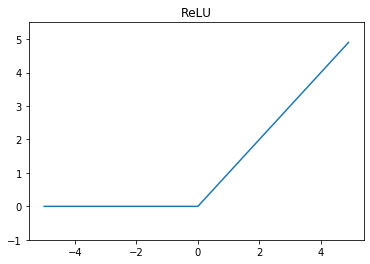

In [12]:
def relu(x):
    return np.maximum(0, x)

x = np.arange(-5.0, 5.0, 0.1)
y = relu(x)
plt.plot(x, y)
plt.ylim(-1.0, 5.5)
plt.title("ReLU")
plt.show()

逆伝播

<img src="./fig/https___qiita-image-store.s3.amazonaws.com_0_197508_e415a0ae-181b-bada-bd81-d18b8064a1d9.png">

In [13]:
#ReLUレイヤ
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x<=0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

reluレイヤは、回路のスイッチみたいな役割

mask

### Sigmoidレイヤ

f(x)⇒　f′(x)f(x)⇒　f′(x)f(x)⇒　f′(x)f(x)⇒　f′(x)=−x=−1=exp(x)=exp(x)=x+1=1=1/x=−1/x2=−f(x)2
f(x)=−x⇒　f′(x)=−1f(x)=exp⁡(x)⇒　f′(x)=exp⁡(x)f(x)=x+1⇒　f′(x)=1f(x)=1/x⇒　f′(x)=−1/x2=−f(x)2
 
∂L∂yy2exp(−x)=∂L∂yyexp(−x)1+exp(−x)=∂L∂yy(1−y)

In [14]:
# Sigmoidレイヤ
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out

        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

# Affine/softmaxレイヤの実装

## Affineレイヤ

アフィン変換  
平面のアフィン変換とは三角形の移動（写像）を与えることで決まる変換のこと

<img src="./fig/deeplearning-5-17-638.jpg">

行列がノード間を移動する

↓ dotの逆伝播では、転置している

<img src="./fig/https___qiita-image-store.s3.amazonaws.com_0_197508_378638c7-59c8-2dec-7388-797657fb002f.png">

## バッチ版affineレイヤ

In [16]:
# バッチ版Affineレイヤ
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.dot(dout, axis=0)

        return dx

## softmax-with-lossレイヤ

softmax関数は、正規化する出力層

softmax関数は、推論と学習のうち、  
学習で必要。  
推論は、値（スコア）の最大値だけに興味があるから。

<img src="./fig/https___qiita-image-store.s3.amazonaws.com_0_197508_f595c37e-25b1-86f9-5d8c-9745244abf37.png">

In [17]:
# SoftmaxWithLoss
class SofmaxWithLoss:
    def __init(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = sofmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx - (self.y - self.t) / bath_size

        return dx

# 誤差逆伝播法の実装

In [18]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads


### 誤差逆伝播法の勾配確認

勾配を求める2つの方法
1. 数値微分　←誤差逆伝播法の結果を確認する。実装がカンタンだから。
2. 解析的に数式を解く　→誤差逆伝播法で大量のパラメータがあってもらくに計算

- 勾配確認

In [21]:
from dataset.mnist import load_mnist
from ch05.two_layer_net import TwoLayerNet

In [22]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))

W1:4.2636733461045854e-10
b1:2.4662202773766478e-09
W2:5.3730763886186606e-09
b2:1.3993429714975747e-07
